In [38]:
import math
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import geojson

# AMOC Online

In [39]:
amoc_online = xr.open_dataset('/pscratch/sd/a/abhi305/MOC/mocStreamvalLatAndDepthRegion_111_112_time_avg.nc')
amoc_onl = amoc_online.timeMonthly_avg_mocStreamvalLatAndDepthRegion[0,0,...]

lat_bins = xr.open_dataset('/pscratch/sd/a/abhi305/MOC/binBoundaryMocStreamfunction.nc').binBoundaryMocStreamfunction
lat_deg = np.degrees(lat_bins.values)

# AMOC calculation (Divergence Method)

## Calculate 'dx' value: for a latitude, what is the distance between two 0.1 degree longitude

In [42]:
# Define latitude values
latitudes = np.linspace(-89.95, 89.95, 1800)  # Assuming a range of latitudes from -90 to 90 degrees

In [62]:
dist_lon = 0.1*111*np.cos(np.deg2rad(latitudes))*1000  # in metres
dist_lat = 11076   # in metres

## Southern Transect 

In [44]:
lev = xr.open_dataset('/pscratch/sd/a/abhi305/depth_files/hr_depth.nc').refBottomDepth
layer_thickness = np.diff(lev, prepend=0)

In [45]:
ds_merv = xr.open_dataset('/pscratch/sd/a/abhi305/Regrided_files_111_120_velocityMeridional/mer_v_highres_111_120_re_time_av.nc')
#ds_merv = xr.open_dataset('/pscratch/sd/a/abhi305/Regrided_files_111_120_timeMonthly_avg_velocityMeridional/timeMonthly_avg_velocityMeridional_111_120_re_time_avg.nc')

merv = ds_merv.timeMonthly_avg_velocityMeridional[0,...]

# topography is problem; set to nan
merv_nan = merv.where(merv != 0, np.nan)

In [46]:
v_south = merv_nan[:,555,1255:1996]

In [47]:
v_south_sum = np.nansum(v_south,axis=1)

In [48]:
v_south_sum.shape

(80,)

In [49]:
v_dx = v_south_sum*9000

## v_dx_dz

In [50]:
#########################################################################################################################
### now v_dx_dz (integrating bottom to top)
#########################################################################################################################

## empty psi south
psi_s = np.zeros_like(v_dx)

for i in range(80):
    psi_s[i] = v_dx[i] * layer_thickness[i]
#psi_s[79] = 0   

psi_sc = np.flip(np.nancumsum(np.flip(psi_s)))

# Read data - vertVelocityTop

In [51]:
ds1 = xr.open_dataset('/pscratch/sd/a/abhi305/Regrided_files_111_120_vertVelocityTop/vertVelocityTop_111_120_re_time_avg.nc')
vt = ds1.timeMonthly_avg_vertVelocityTop[0,...]

lat = ds1.lat
lon = ds1.lon

# topography is problem; set to nan
vt = vt.where(vt != 0, np.nan)

# Select Interior Region

In [52]:
with open('/pscratch/sd/a/abhi305/mask_files/atlantic_mask.geojson') as f:
    fc = geojson.load(f) 

In [53]:
from mpas_tools.mesh.creation.signed_distance import mask_from_geojson

In [54]:
na_mask = mask_from_geojson(fc,lon,lat)

Mask from geojson
-----------------


In [55]:
w = vt.values

In [56]:
w[:,~na_mask] = np.nan

In [57]:
#plt.pcolormesh(vt[0,...],cmap='RdBu')
#plt.colorbar()

In [58]:
np.shape(w)

(81, 1800, 3600)

# w_dA

In [73]:
w_sum = np.nansum(w,axis=2)

In [74]:
## BUT ACTUALLY AN EMPTY SET (tmp) - sum of vertical vel along a latitude
w_da = np.zeros_like(w_sum)

In [75]:
w_da.shape

(81, 1800)

In [76]:
for i in tqdm(range(len(dist))):
    w_da[:,i] = w_sum[:,i] * (dist_lon[i]) * dist_lat

100%|██████████| 1800/1800 [00:00<00:00, 225810.47it/s]


## Adding bottom to top

### cumsum in depth

In [77]:
## empty psi
psi = np.zeros_like(w_da)

for i in tqdm(range(len(lat))):
    for j in range(80):
        psi[j,i] = w_da[j+1,i]-w_da[j,i]

#psi = psi[0:80, :]

psi_c = np.flip(np.nancumsum(np.flip(psi, axis=0), axis=0), axis=0) # taking cumsum in z axis

100%|██████████| 1800/1800 [00:00<00:00, 30553.16it/s]


### Taking cumsum in latitudes

In [78]:
psi_clat = np.nancumsum(psic, axis=1)

# Add southern Transect

In [81]:
psiclat.shape

(81, 1800)

In [84]:
# In Sverdrups
amoc_calc = np.zeros_like(psi_clat[0:80,:])
for i in range(1800):
    amoc_calc[:,i] = -0.000001*(psi_clat[0:80,i]+psi_sc)

# PLOT
AMOC by divergence method

/tmp/ipykernel_2357666/3299515894.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


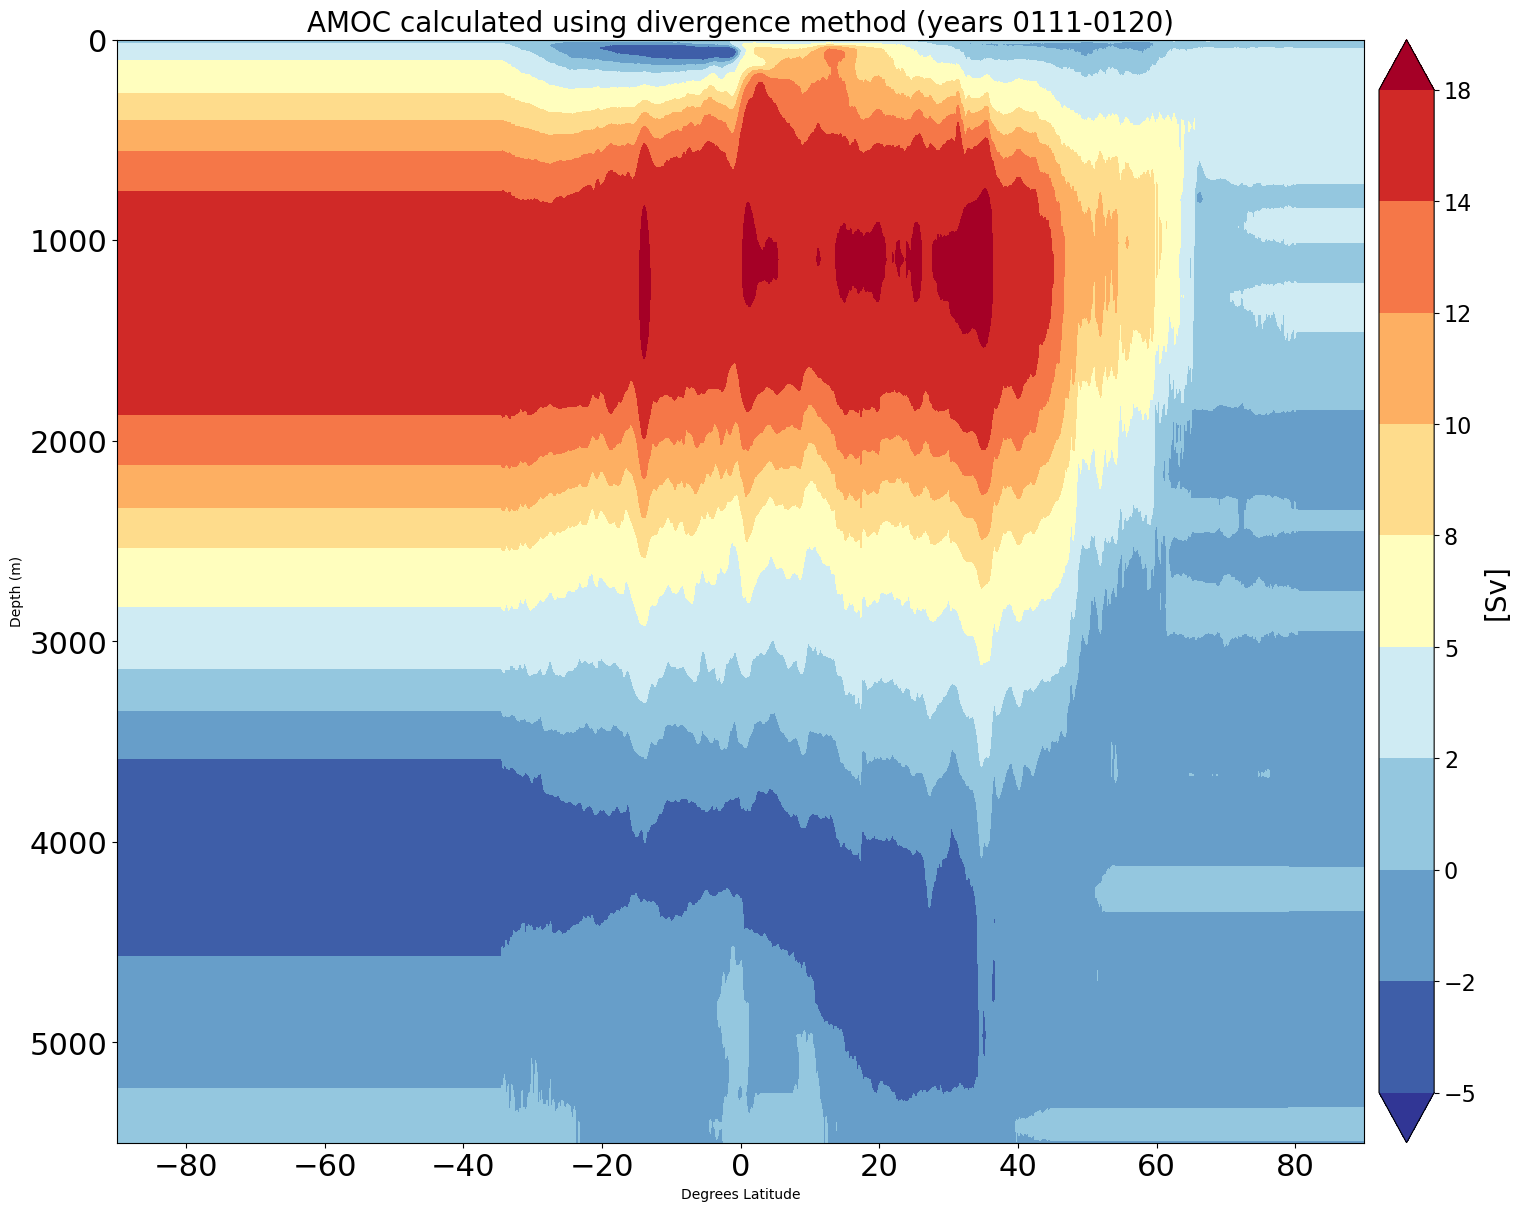

In [86]:
cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat.values, lev, amoc_calc,                  
             levels=np.array([-5,-2,0,2,5,8,10,12,14,18]) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC calculated using divergence method (years 0111-0120)',fontsize=20)
fig.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_calculated_div_years_0111_0120', dpi=300)

## Interpolate from calculated AMOC to lat_deg of online AMOC for comparison

In [87]:
amoc_calc.shape

(80, 1800)

In [88]:
from scipy.interpolate import interp1d

In [89]:
interp_func = interp1d(lat.values, amoc_calc, axis=1, bounds_error=False, fill_value="extrapolate")
amoc_interp = interp_func(lat_deg)

## Plots of amoc_interp and amoc_onl 

/tmp/ipykernel_2357666/126343264.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


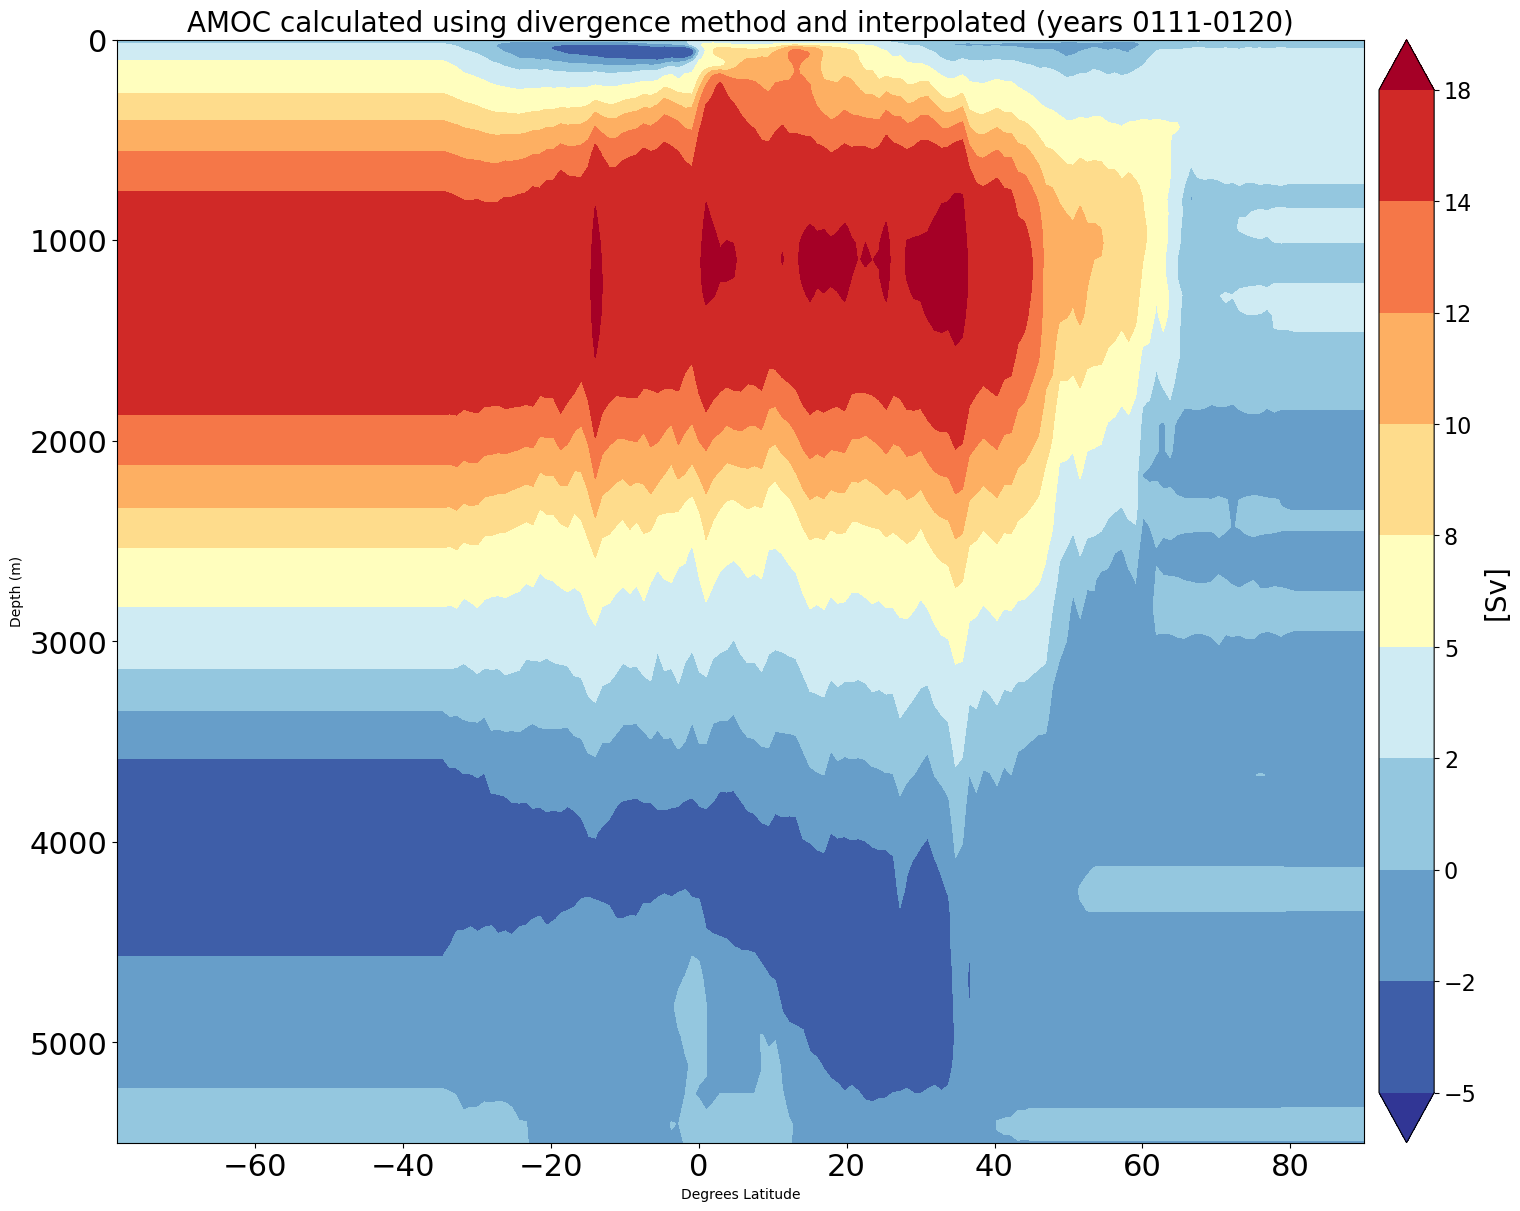

In [90]:

cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat_deg, lev, amoc_interp,                  
             levels=np.array([-5,-2,0,2,5,8,10,12,14,18]) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC calculated using divergence method and interpolated (years 0111-0120)',fontsize=20)
fig.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_calculated_div_n_interpolated_years_0111_0120', dpi=300)

/tmp/ipykernel_2357666/2653295758.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


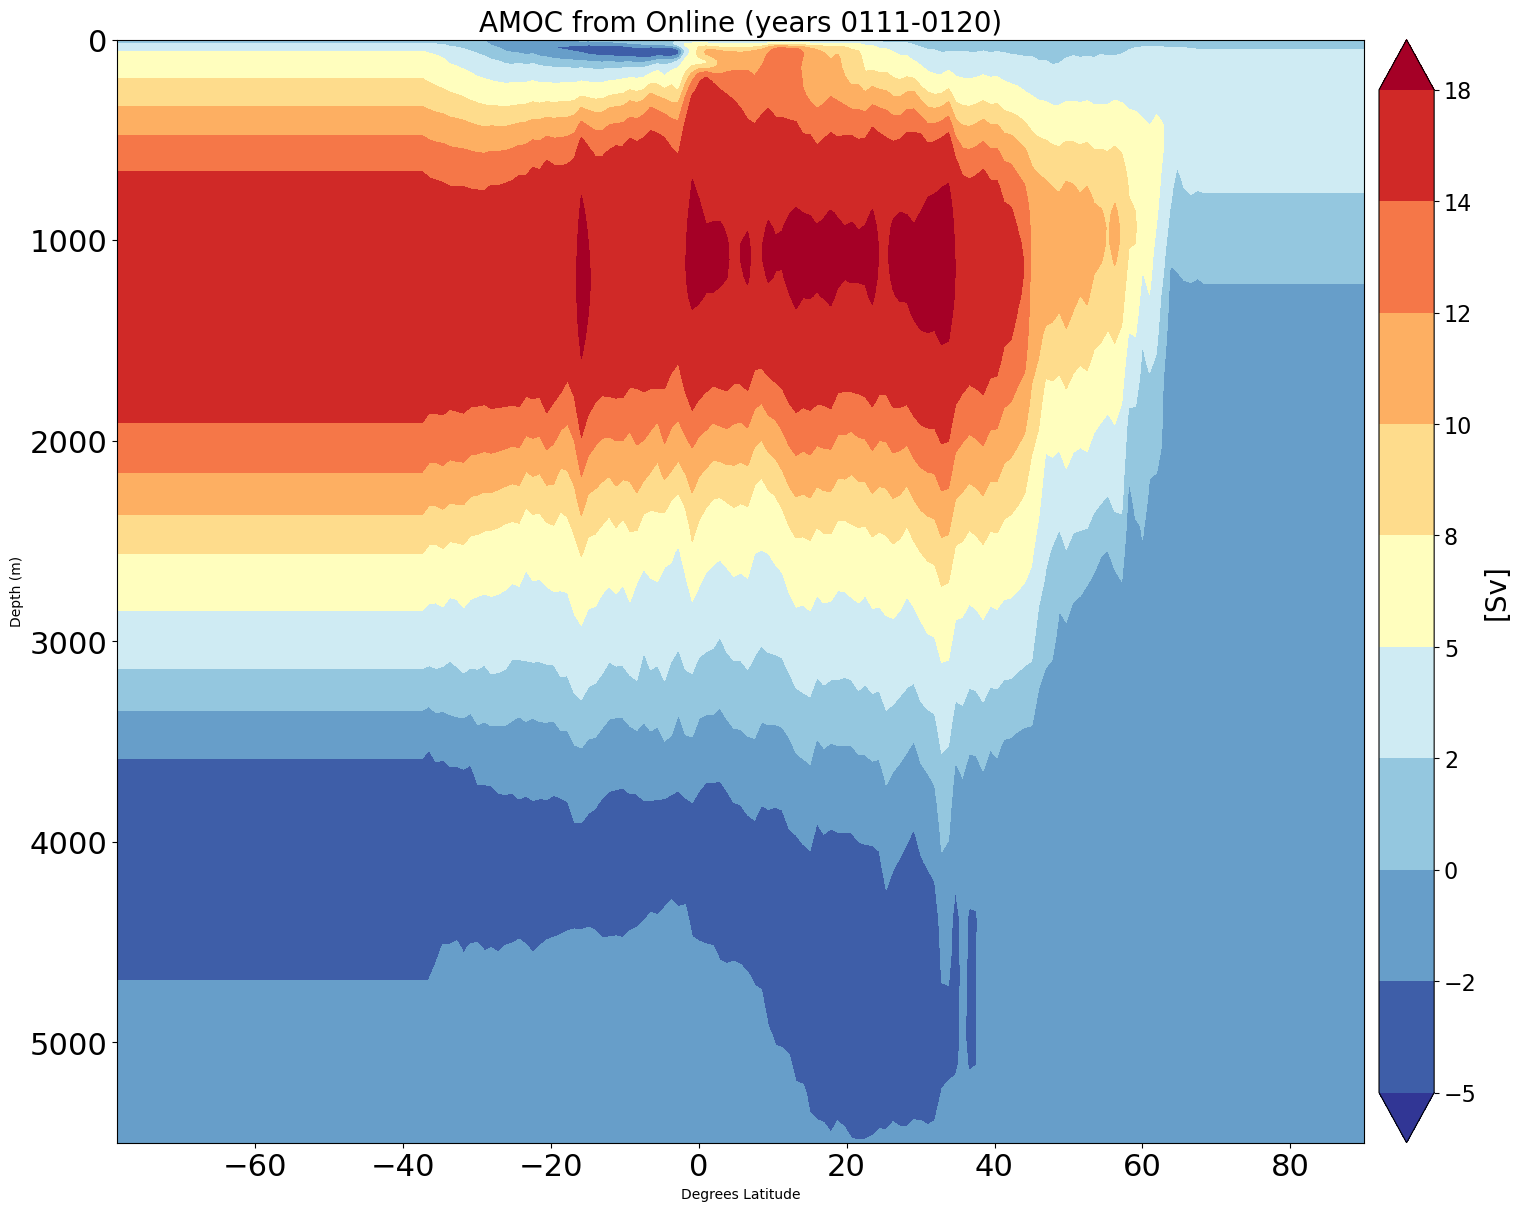

In [91]:

cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat_deg, lev, amoc_onl,                  
             levels=np.array([-5,-2,0,2,5,8,10,12,14,18]) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC from Online (years 0111-0120)',fontsize=20)
fig.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_from_Online_years_0111_0120', dpi=300)

# add a small box to the bottom corner representing zpo.max()

## Difference plot

/tmp/ipykernel_2357666/2571335089.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


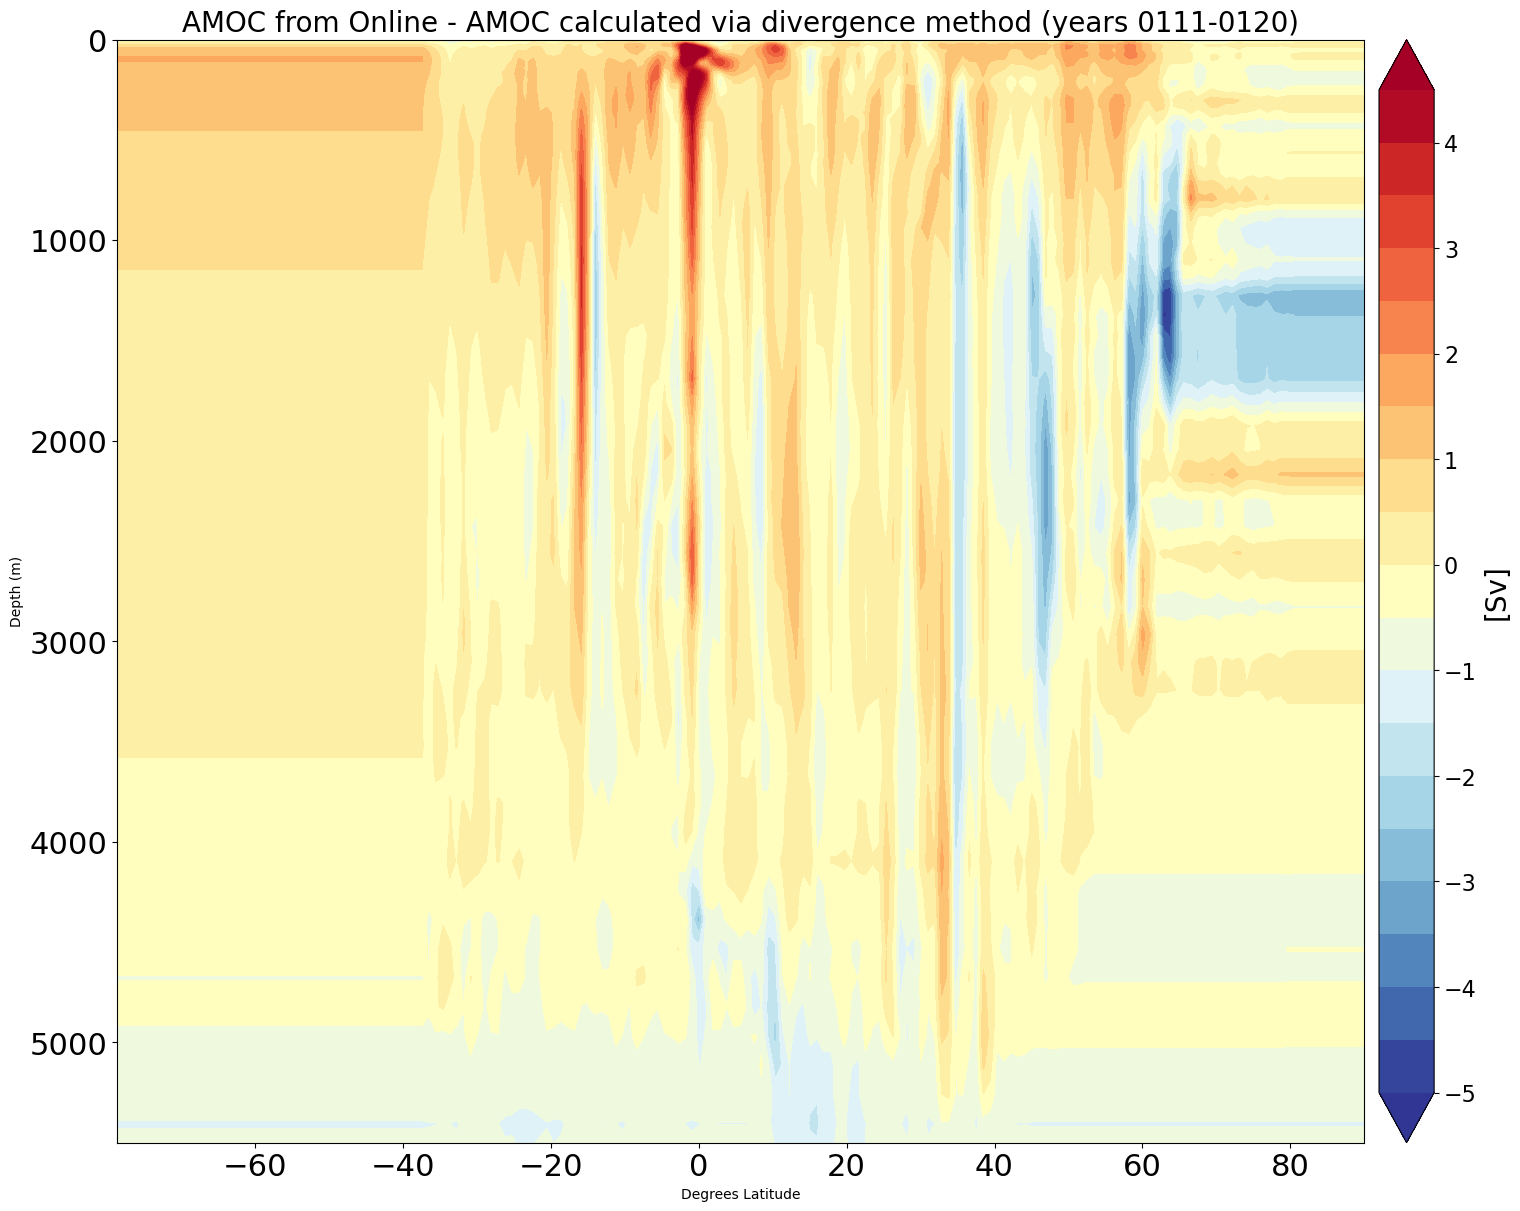

In [93]:

cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat_deg, lev, amoc_onl - amoc_interp,                  
             levels=np.arange(-5,5,0.5) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
#iso=ax.contour(xp, yp, rh, colors='tab:green', linestyles='--', linewidths=1.5)
#ax.clabel(iso, fmt='%d')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC from Online - AMOC calculated via divergence method (years 0111-0120)',fontsize=20)
fig.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/difference_Online_vs_calc_div_0111_0120', dpi=300)

# add a small box to the bottom corner representing zpo.max()

# Some Depth Profiles:
30S, 0N, 26.5N, 45N, 47N \
lat[555] is -34.45

In [94]:
selected_lats = np.array([-30.05, 0.01, 26.51, 45.05, 47.05])
selected_lats = lat.sel({'lat': selected_lats}, method='nearest').indexes['lat']
selected_lats_indices = np.where(np.isin(lat.values, selected_lats))[0]

print(selected_lats_indices)

[ 599  900 1165 1350 1370]


In [95]:
lat[selected_lats_indices].values

array([-30.05,   0.05,  26.55,  45.05,  47.05])

## Select this lats for AMOC

In [96]:
amoc_sel = amoc_calc[:,selected_lats_indices]

## Plot

Text(0.5, 1.0, 'Depth profiles of the AMOC stream function for E3SM high-res (last 10 years) (Divergence method)')

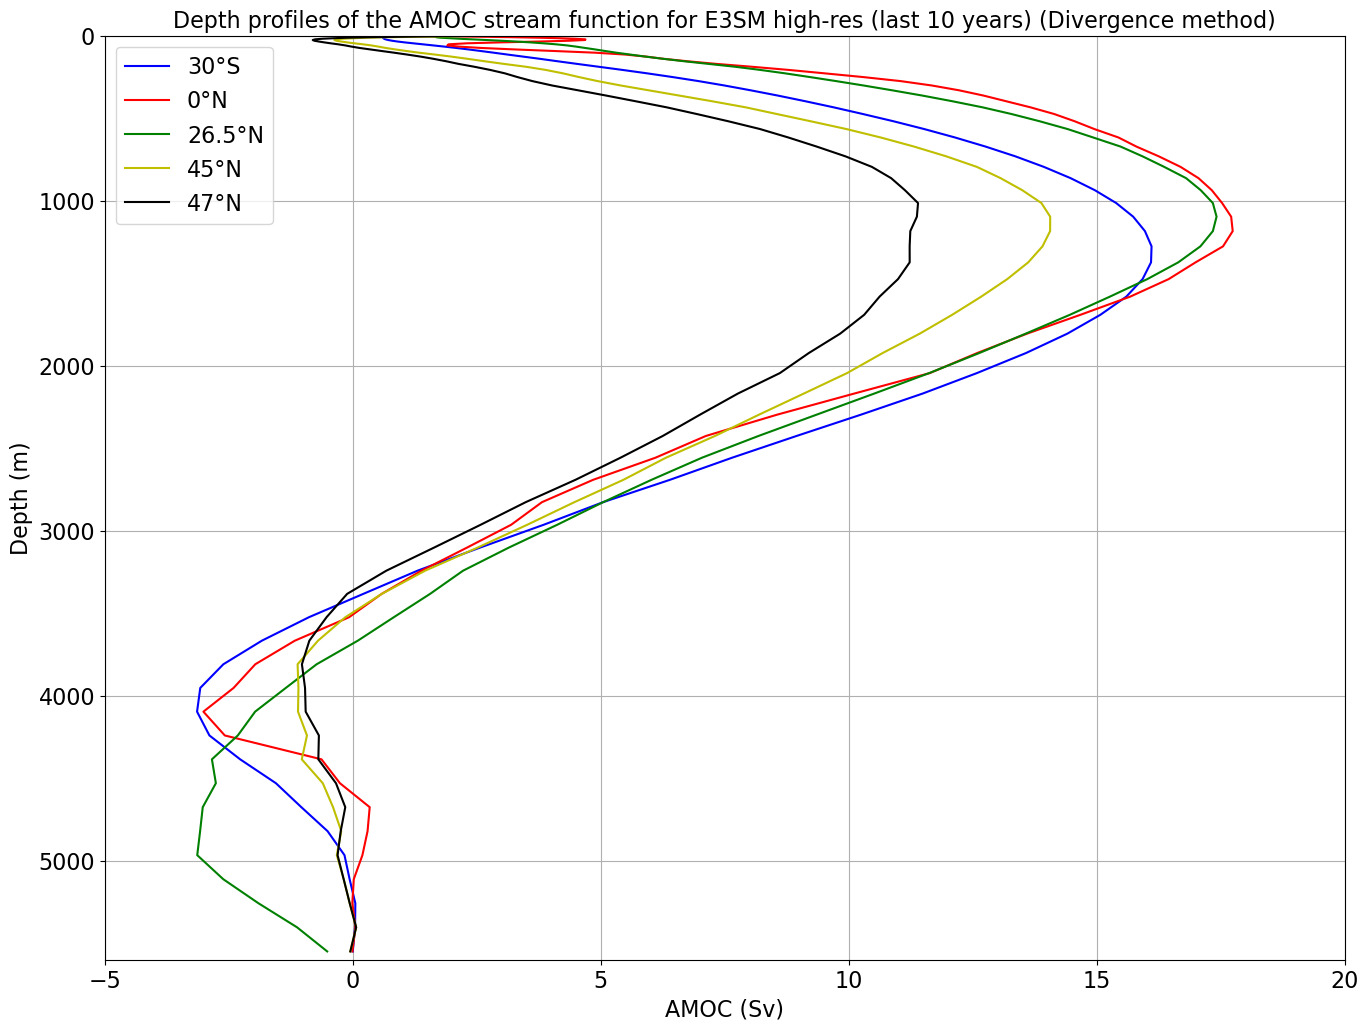

In [97]:
plt.figure(figsize=(16, 12))
plt.plot(amoc_sel[:,0],lev, label='30°S',c='b')
plt.plot(amoc_sel[:,1],lev, label='0°N',c='r')
plt.plot(amoc_sel[:,2],lev, label='26.5°N',c='g')
plt.plot(amoc_sel[:,3],lev, label='45°N',c='y')
plt.plot(amoc_sel[:,4],lev, label='47°N',c='k')
plt.grid()
plt.xlim(-5,20)
plt.ylim(5600,0)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('AMOC (Sv)',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
plt.legend(fontsize=16)
plt.title('Depth profiles of the AMOC stream function for E3SM high-res (last 10 years) (Divergence method)',fontsize=16)

In [98]:
# 30°S

# AMOC calculation (dx.dz)

- merv_nan is the xarray of all v's


In [99]:
v = merv_nan.values

In [100]:
v[:,~na_mask] = np.nan

## V_dx

In [101]:
v_sum = np.nansum(v,axis=2)

In [102]:
v_dx = np.zeros_like(v_sum)
for i in tqdm(range(len(dist))):
    v_dx[:,i] = v_sum[:,i] * dist[i]

100%|██████████| 1800/1800 [00:00<00:00, 351592.57it/s]


# 1- v_dx_dz (integrating top to bottom)

In [103]:
psi_dxdz_tb_prime = v_dx * layer_thickness[:,None] 
psi_dxdz_tb = 0.000001 * np.nancumsum(psi_dxdz_tb_prime, axis=0)

# 2- v_dx_dz (integrating bottom to top)

In [104]:
psi_dxdz_bt_prime = v_dx * layer_thickness[:,None] 
psi_dxdz_bt = -0.000001 * np.flip(np.nancumsum(np.flip(psi_dxdz_bt_prime, axis=0),axis=0),axis=0)

# PLOTS

/tmp/ipykernel_2357666/2219084305.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


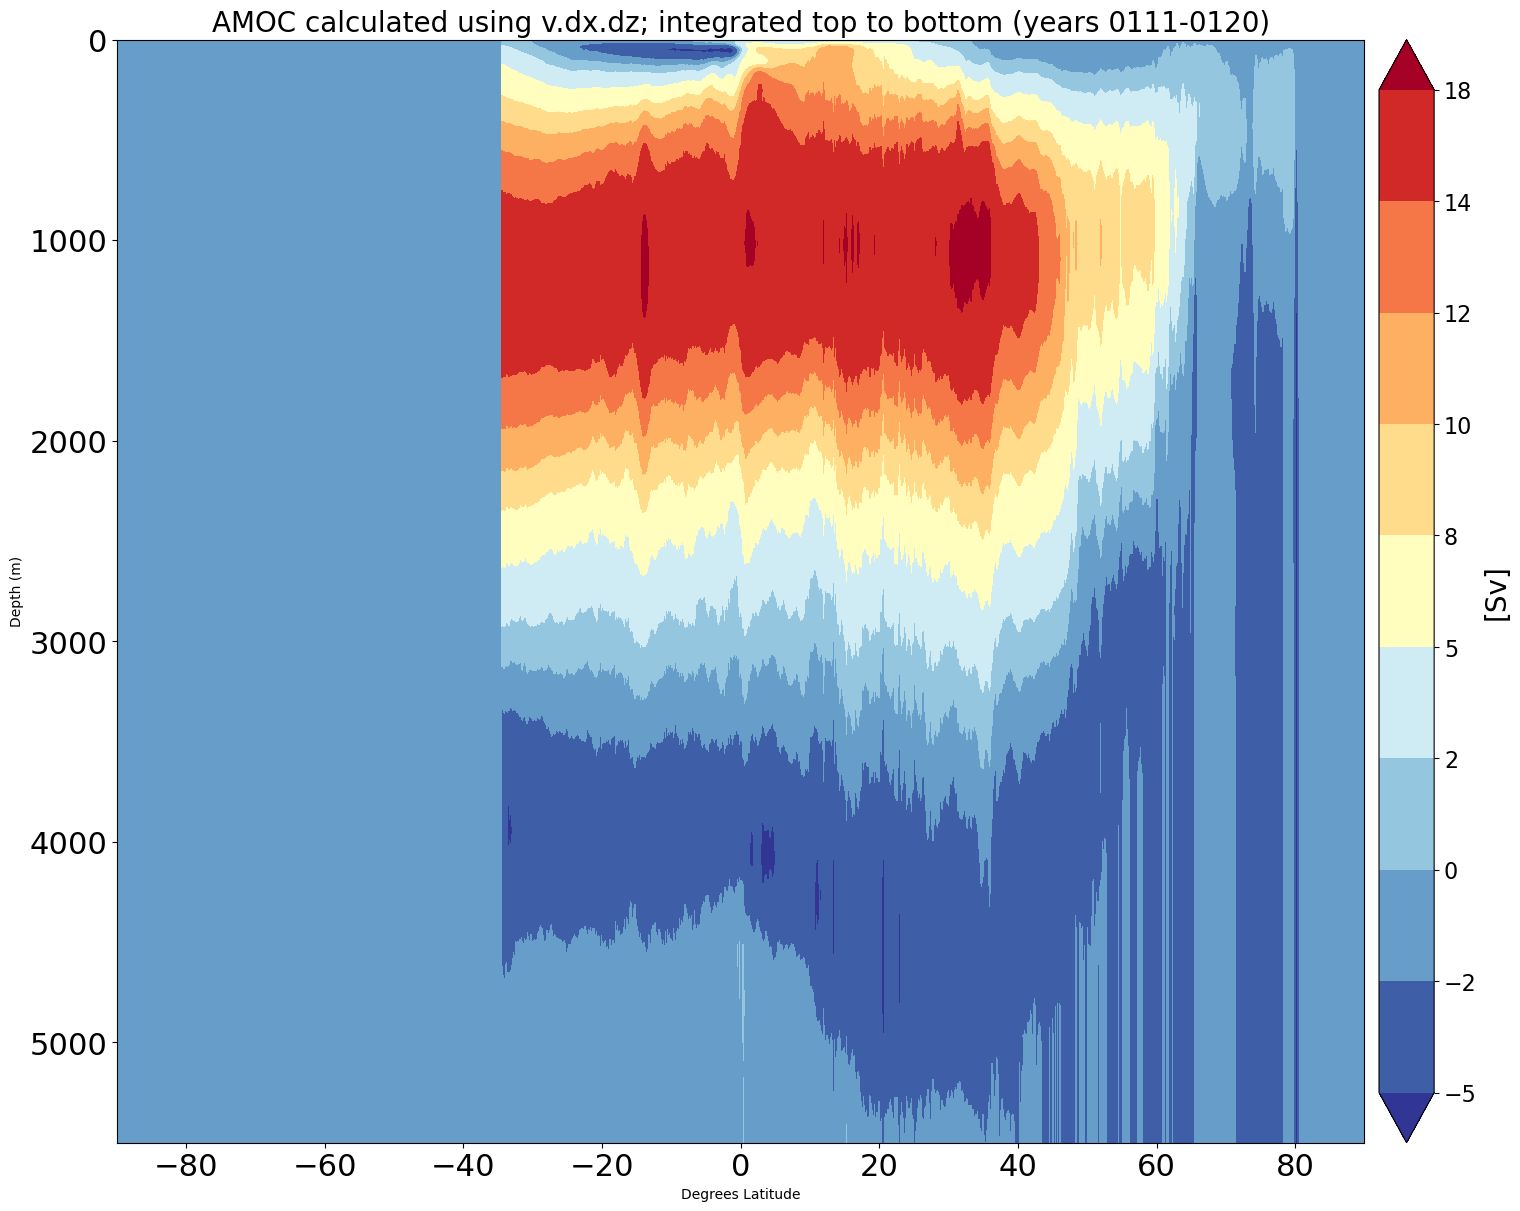

In [105]:
cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat.values, lev, psi_dxdz_tb,                  
             levels=np.array([-5,-2,0,2,5,8,10,12,14,18]) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC calculated using v.dx.dz; integrated top to bottom (years 0111-0120)',fontsize=20)
fig.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_calculated_vdxdz_tb_0111_0120', dpi=300)

/tmp/ipykernel_2357666/3997732128.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


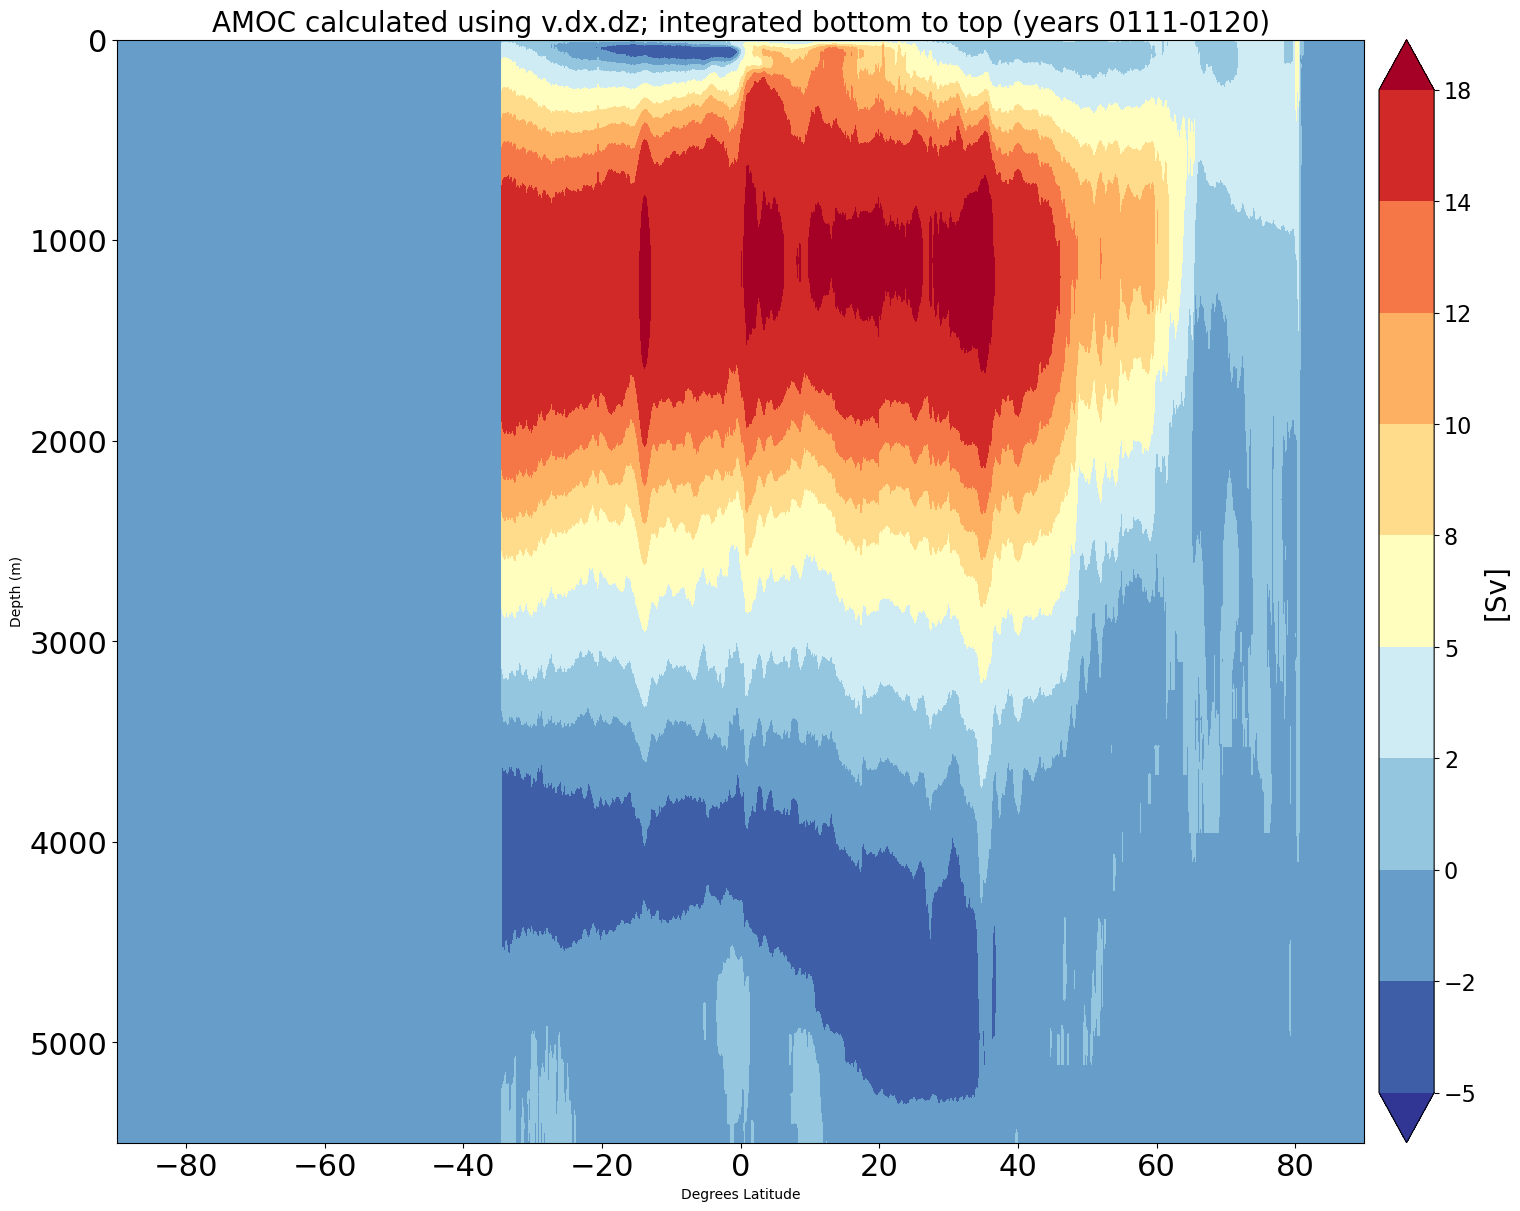

In [106]:
cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat.values, lev, psi_dxdz_bt,                  
             levels=np.array([-5,-2,0,2,5,8,10,12,14,18]) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC calculated using v.dx.dz; integrated bottom to top (years 0111-0120)',fontsize=20)
fig.tight_layout(pad=0.3)
fig.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_calculated_vdxdz_bt_0111_0120', dpi=300)

# Compare with AMOC Online

## Interpolate from calculated AMOC to lat_deg of online AMOC for comparison

In [107]:
from scipy.interpolate import interp1d

In [108]:
interp_func_tb = interp1d(lat.values, psi_dxdz_tb, axis=1, bounds_error=False, fill_value="extrapolate")
amoc_interp_tb = interp_func_tb(lat_deg)

In [109]:
interp_func_bt = interp1d(lat.values, psi_dxdz_bt, axis=1, bounds_error=False, fill_value="extrapolate")
amoc_interp_bt = interp_func_bt(lat_deg)

## Plots

/tmp/ipykernel_2357666/4254315501.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


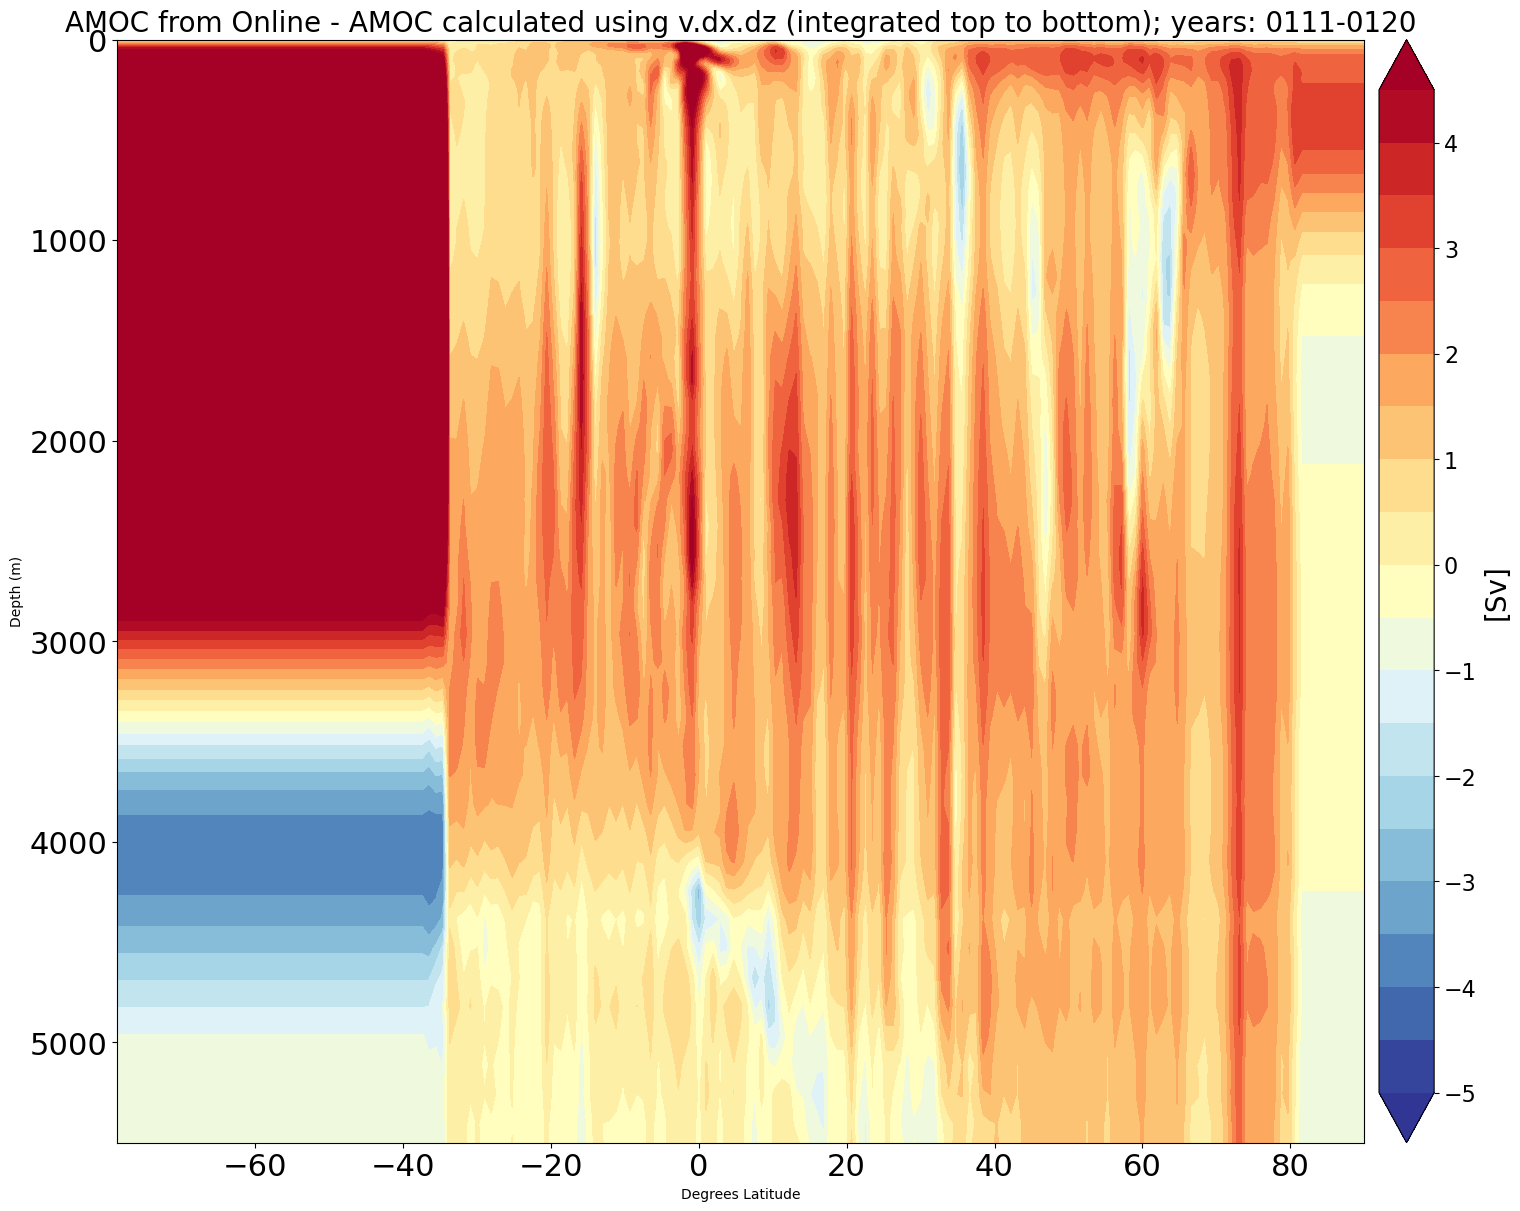

In [110]:
cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat_deg, lev, amoc_onl - amoc_interp_tb,                  
             levels=np.arange(-5,5,0.5) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
#iso=ax.contour(xp, yp, rh, colors='tab:green', linestyles='--', linewidths=1.5)
#ax.clabel(iso, fmt='%d')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC from Online - AMOC calculated using v.dx.dz (integrated top to bottom); years: 0111-0120',fontsize=20)
fig.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/difference_Online_vs_calc_vdxdz_tb_0111_0120', dpi=300)

/tmp/ipykernel_2357666/1022550553.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


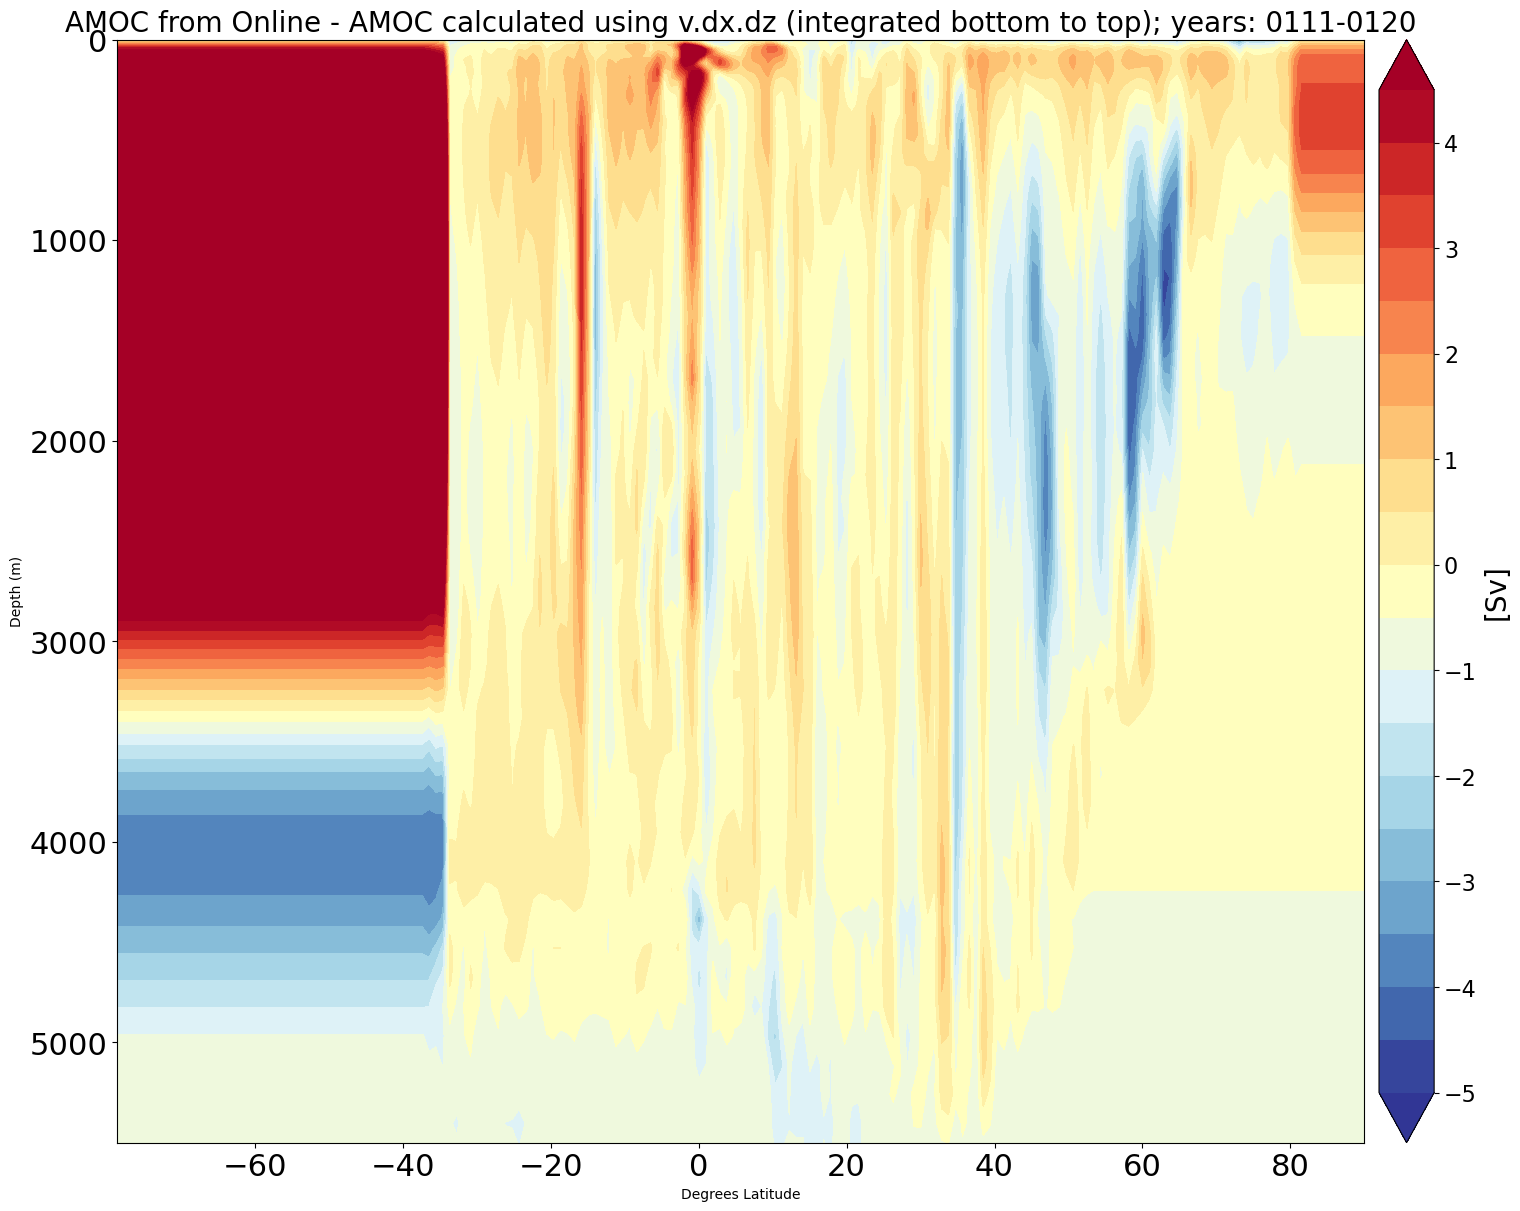

In [111]:
cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat_deg, lev, amoc_onl - amoc_interp_bt,                  
             levels=np.arange(-5,5,0.5) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
#iso=ax.contour(xp, yp, rh, colors='tab:green', linestyles='--', linewidths=1.5)
#ax.clabel(iso, fmt='%d')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC from Online - AMOC calculated using v.dx.dz (integrated bottom to top); years: 0111-0120',fontsize=20)
fig.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/difference_Online_vs_calc_vdxdz_bt_0111_0120', dpi=300)

/tmp/ipykernel_2357666/460329403.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu')


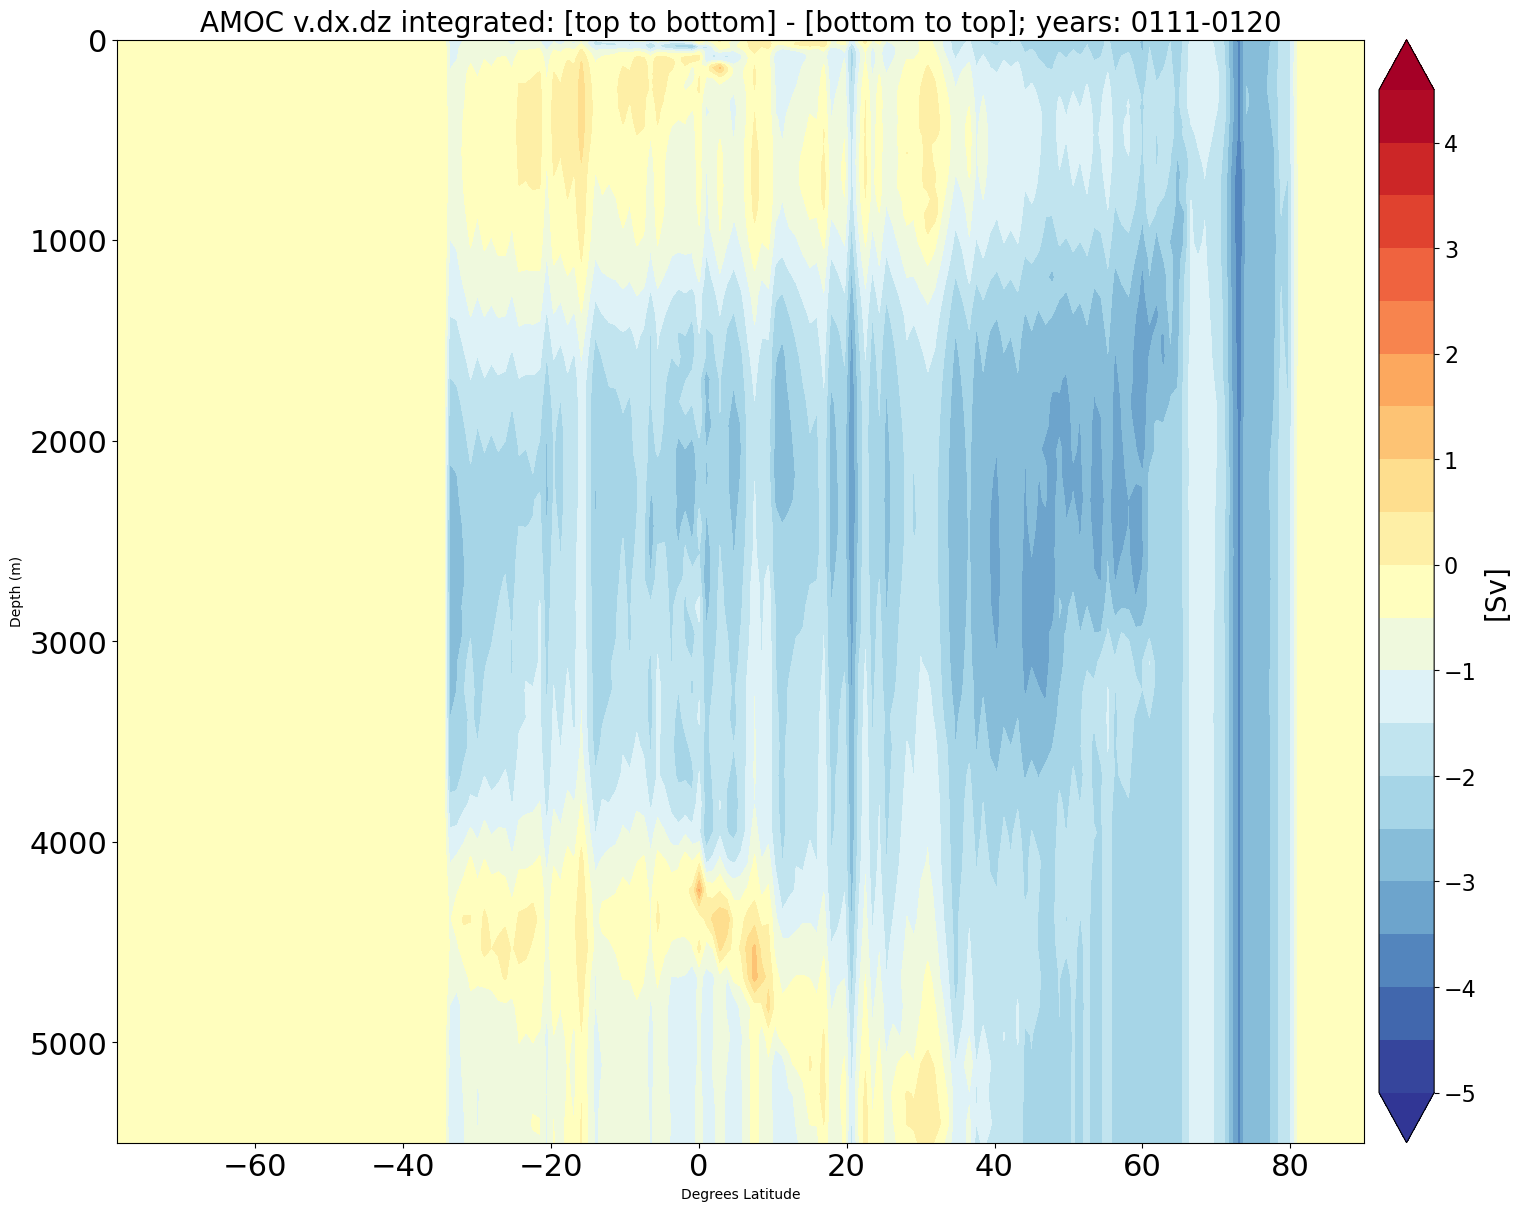

In [112]:
cmap = plt.cm.get_cmap('RdYlBu')
cmap_reversed = cmap.reversed()

fig, ax = plt.subplots(figsize=(16, 12))
cons=ax.contourf(lat_deg, lev, amoc_interp_tb - amoc_interp_bt,                  
             levels=np.arange(-5,5,0.5) ,
             #vmin = -2, vmax= 2,
             cmap=cmap_reversed,extend='both')
#iso=ax.contour(xp, yp, rh, colors='tab:green', linestyles='--', linewidths=1.5)
#ax.clabel(iso, fmt='%d')
ax.set_ylim(5500,0)
plt.gca().set_facecolor("grey")  # nan values to grey
cbar = fig.colorbar(cons, orientation='vertical', pad=0.01)
cbar.set_label('[Sv]', size=20)
cbar.ax.tick_params(labelsize=16)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Degrees Latitude')
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title('AMOC v.dx.dz integrated: [top to bottom] - [bottom to top]; years: 0111-0120',fontsize=20)
fig.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/difference_vdxdz_tb_bt_0111_0120', dpi=300)

# Depth profiles comparison

In [113]:
selected_lats = np.array([-30.05, 0.01, 26.51, 45.05, 47.05])
selected_lats = lat.sel({'lat': selected_lats}, method='nearest').indexes['lat']
selected_lats_indices = np.where(np.isin(lat.values, selected_lats))[0]

print(selected_lats_indices)

[ 599  900 1165 1350 1370]


In [114]:
lat[selected_lats_indices].values

array([-30.05,   0.05,  26.55,  45.05,  47.05])

## Select the amocs for the lats

In [115]:
amoc_sel_da = amoc_calc[:,selected_lats_indices]
amoc_sel_dxdz_tb = psi_dxdz_tb[:,selected_lats_indices]
amoc_sel_dxdz_bt = psi_dxdz_bt[:,selected_lats_indices]

### 30°S 

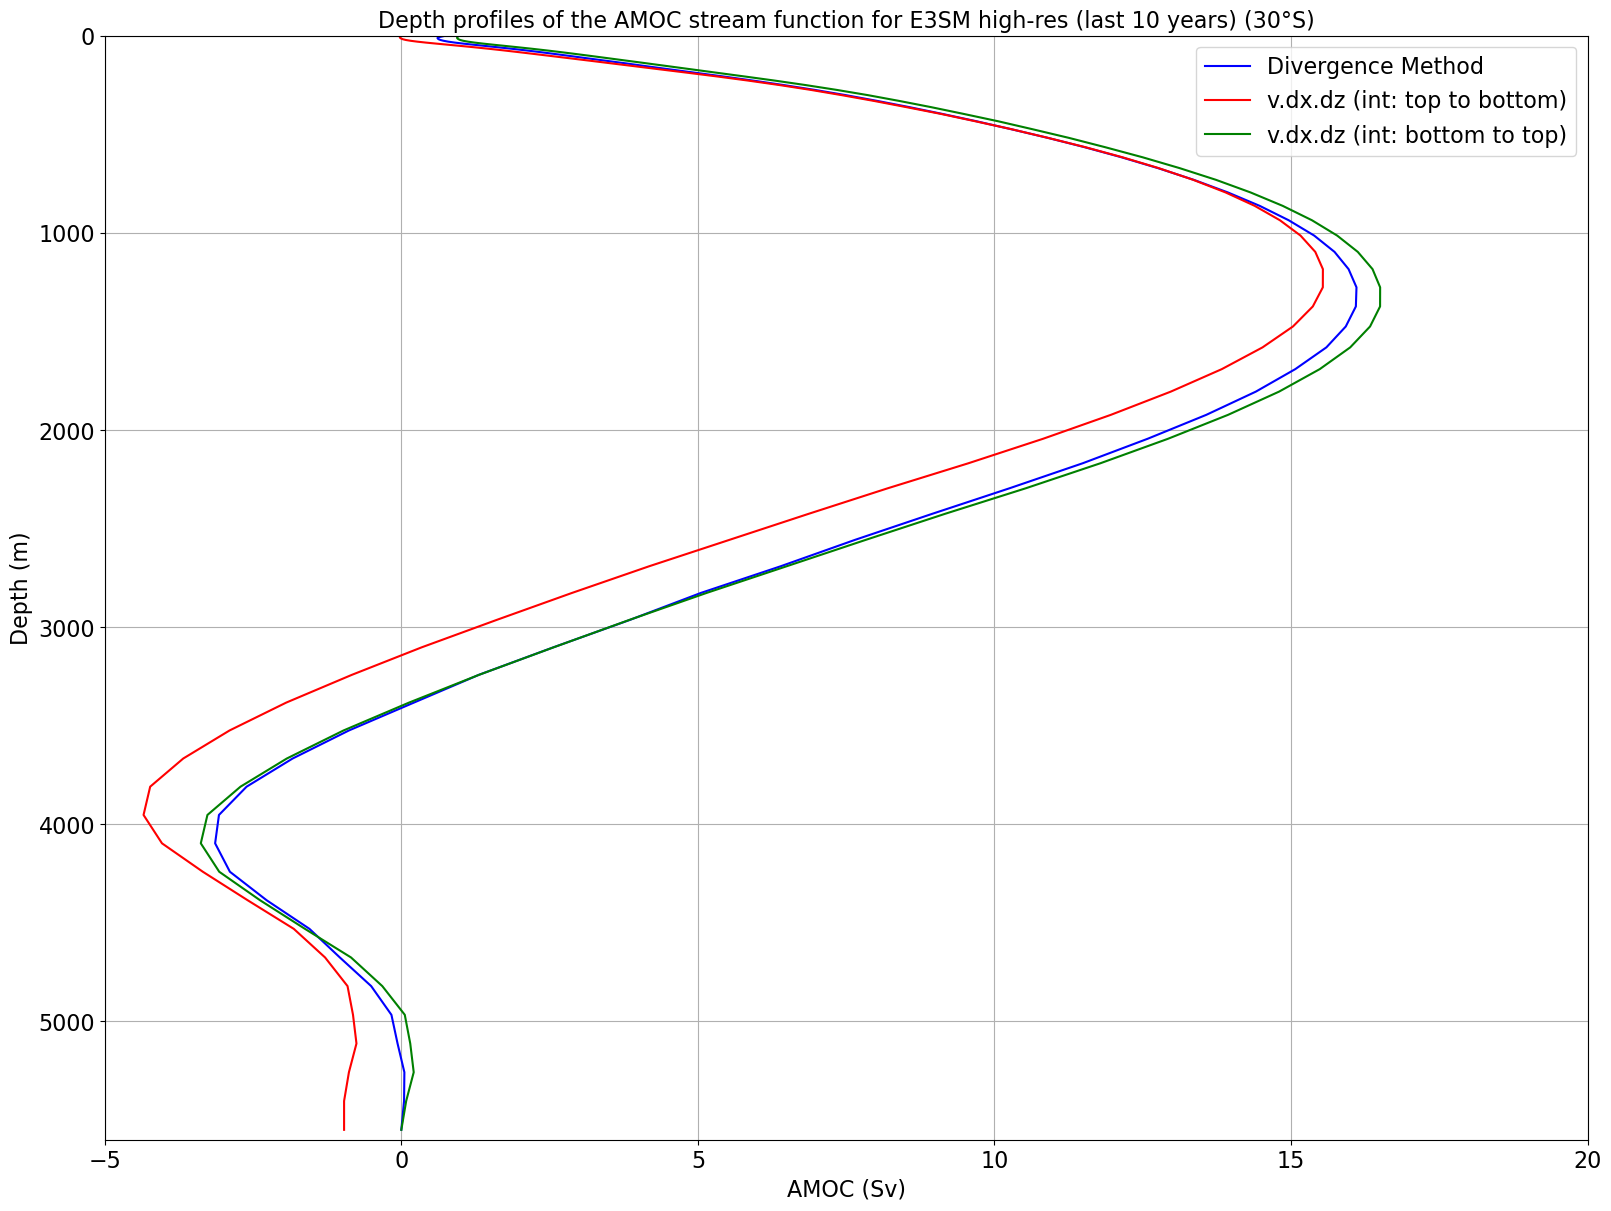

In [116]:
plt.figure(figsize=(16, 12))
plt.plot(amoc_sel_da[:,0],lev, label='Divergence Method',c='b')
plt.plot(amoc_sel_dxdz_tb[:,0],lev, label='v.dx.dz (int: top to bottom)',c='r')
plt.plot(amoc_sel_dxdz_bt[:,0],lev, label='v.dx.dz (int: bottom to top)',c='g')
plt.grid()
plt.xlim(-5,20)
plt.ylim(5600,0)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('AMOC (Sv)',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
plt.legend(fontsize=16)
plt.title('Depth profiles of the AMOC stream function for E3SM high-res (last 10 years) (30°S)',fontsize=16)
plt.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_depth_profile_30S', dpi=300)

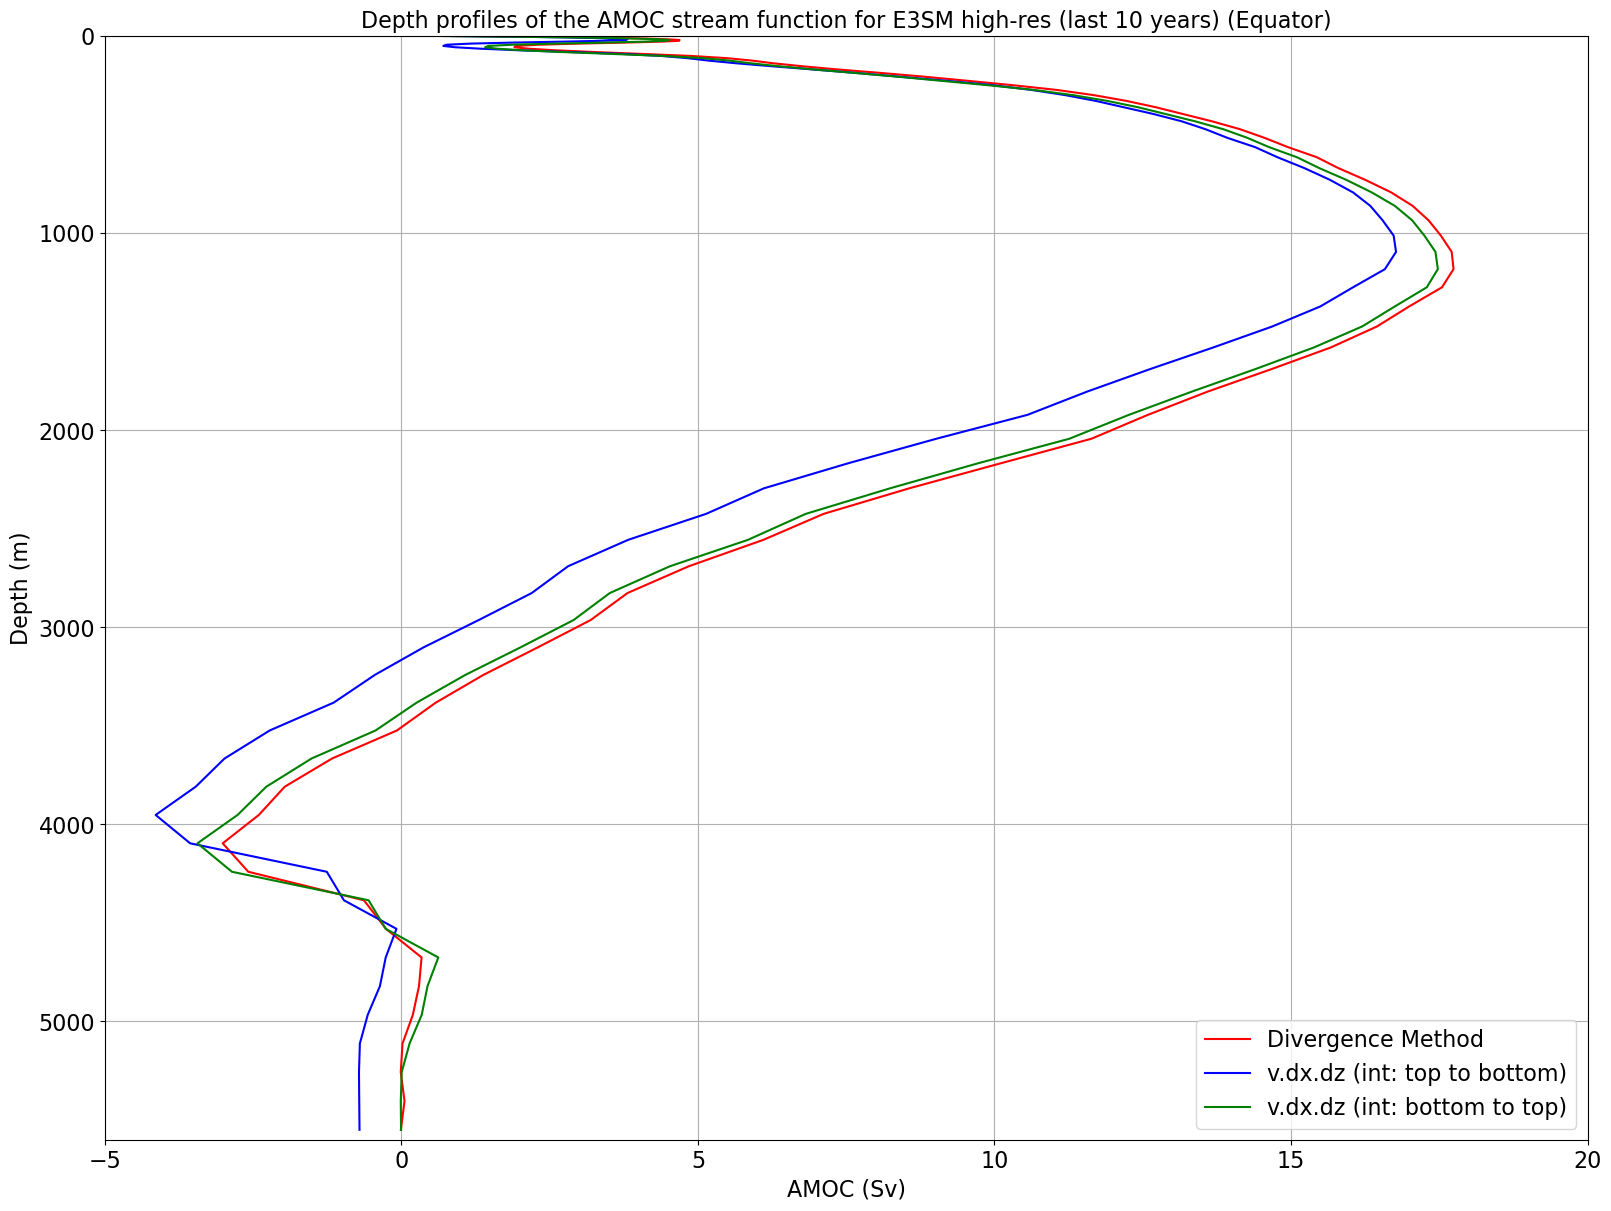

In [117]:
plt.figure(figsize=(16, 12))
plt.plot(amoc_sel_da[:,1],lev, label='Divergence Method',c='r')
plt.plot(amoc_sel_dxdz_tb[:,1],lev, label='v.dx.dz (int: top to bottom)',c='b')
plt.plot(amoc_sel_dxdz_bt[:,1],lev, label='v.dx.dz (int: bottom to top)',c='g')
plt.grid()
plt.xlim(-5,20)
plt.ylim(5600,0)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('AMOC (Sv)',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
plt.legend(fontsize=16)
plt.title('Depth profiles of the AMOC stream function for E3SM high-res (last 10 years) (Equator)',fontsize=16)
plt.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_depth_profile_0N', dpi=300)

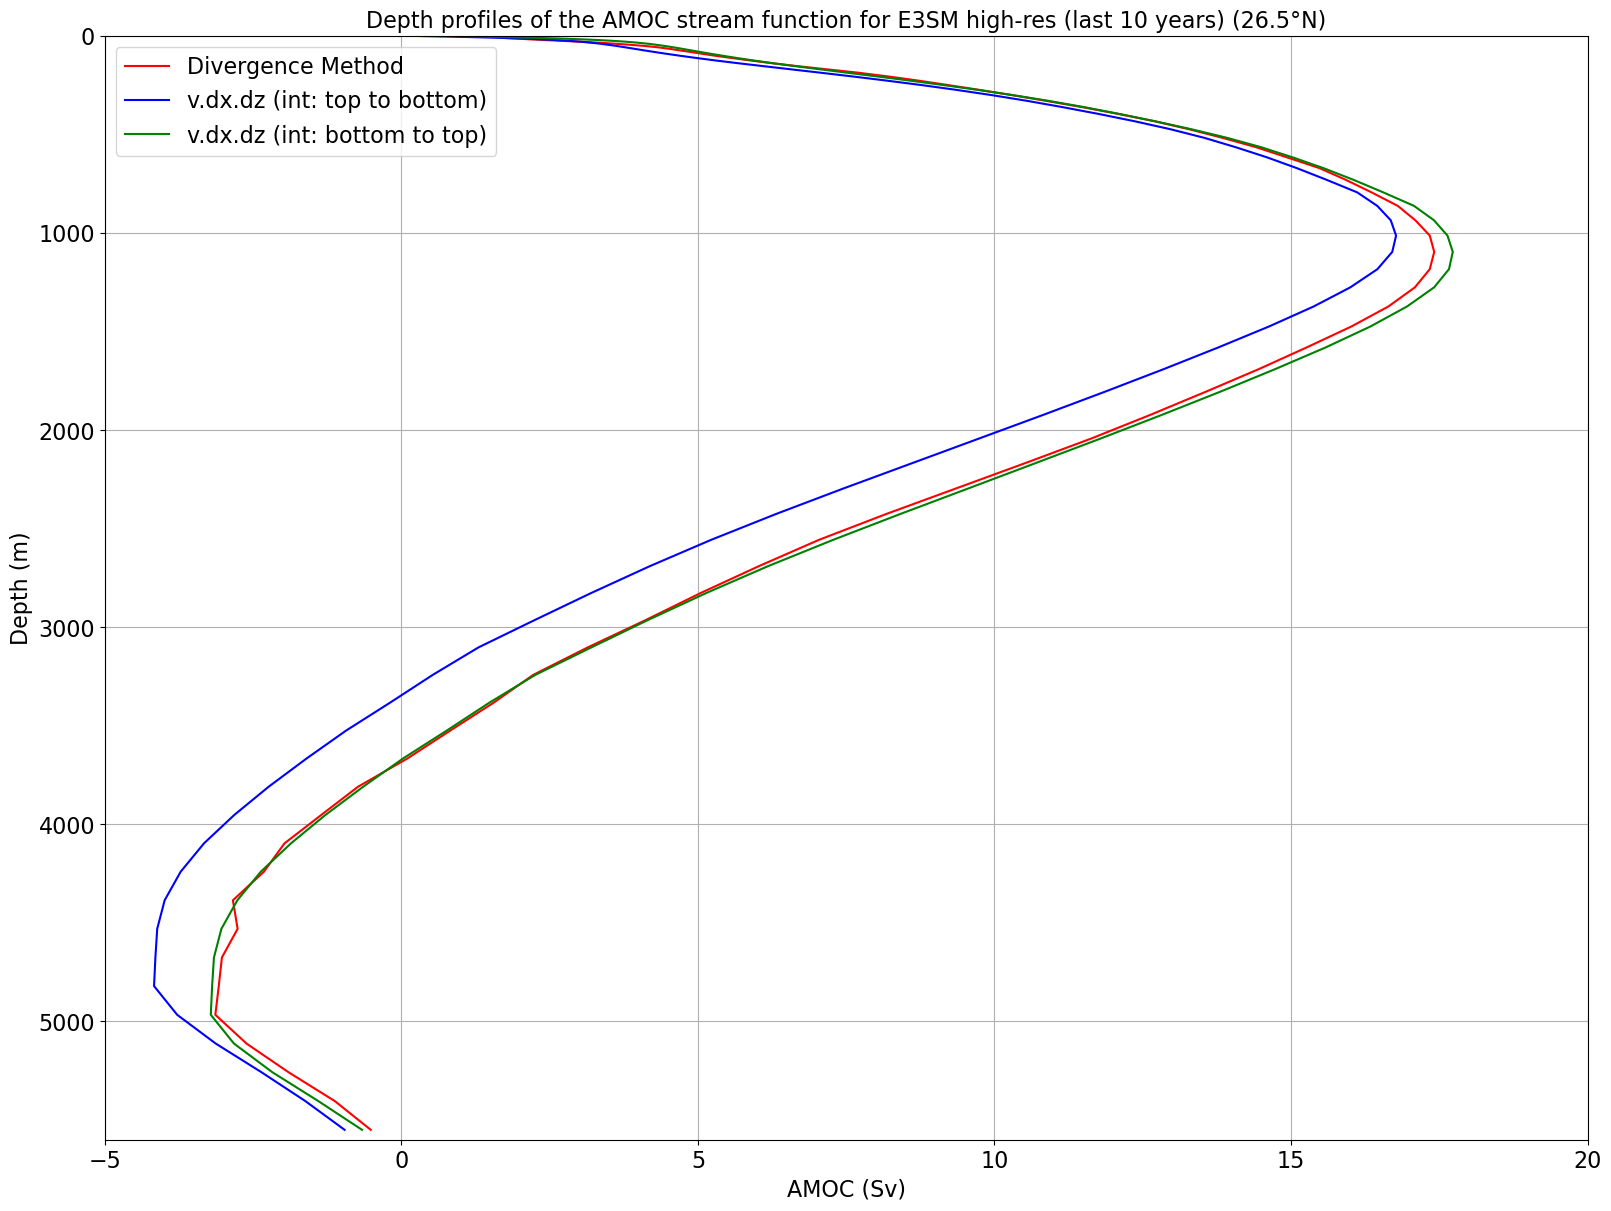

In [118]:
plt.figure(figsize=(16, 12))
plt.plot(amoc_sel_da[:,2],lev, label='Divergence Method',c='r')
plt.plot(amoc_sel_dxdz_tb[:,2],lev, label='v.dx.dz (int: top to bottom)',c='b')
plt.plot(amoc_sel_dxdz_bt[:,2],lev, label='v.dx.dz (int: bottom to top)',c='g')
plt.grid()
plt.xlim(-5,20)
plt.ylim(5600,0)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('AMOC (Sv)',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
plt.legend(fontsize=16)
plt.title('Depth profiles of the AMOC stream function for E3SM high-res (last 10 years) (26.5°N)',fontsize=16)
plt.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_depth_profile_26_5N', dpi=300)

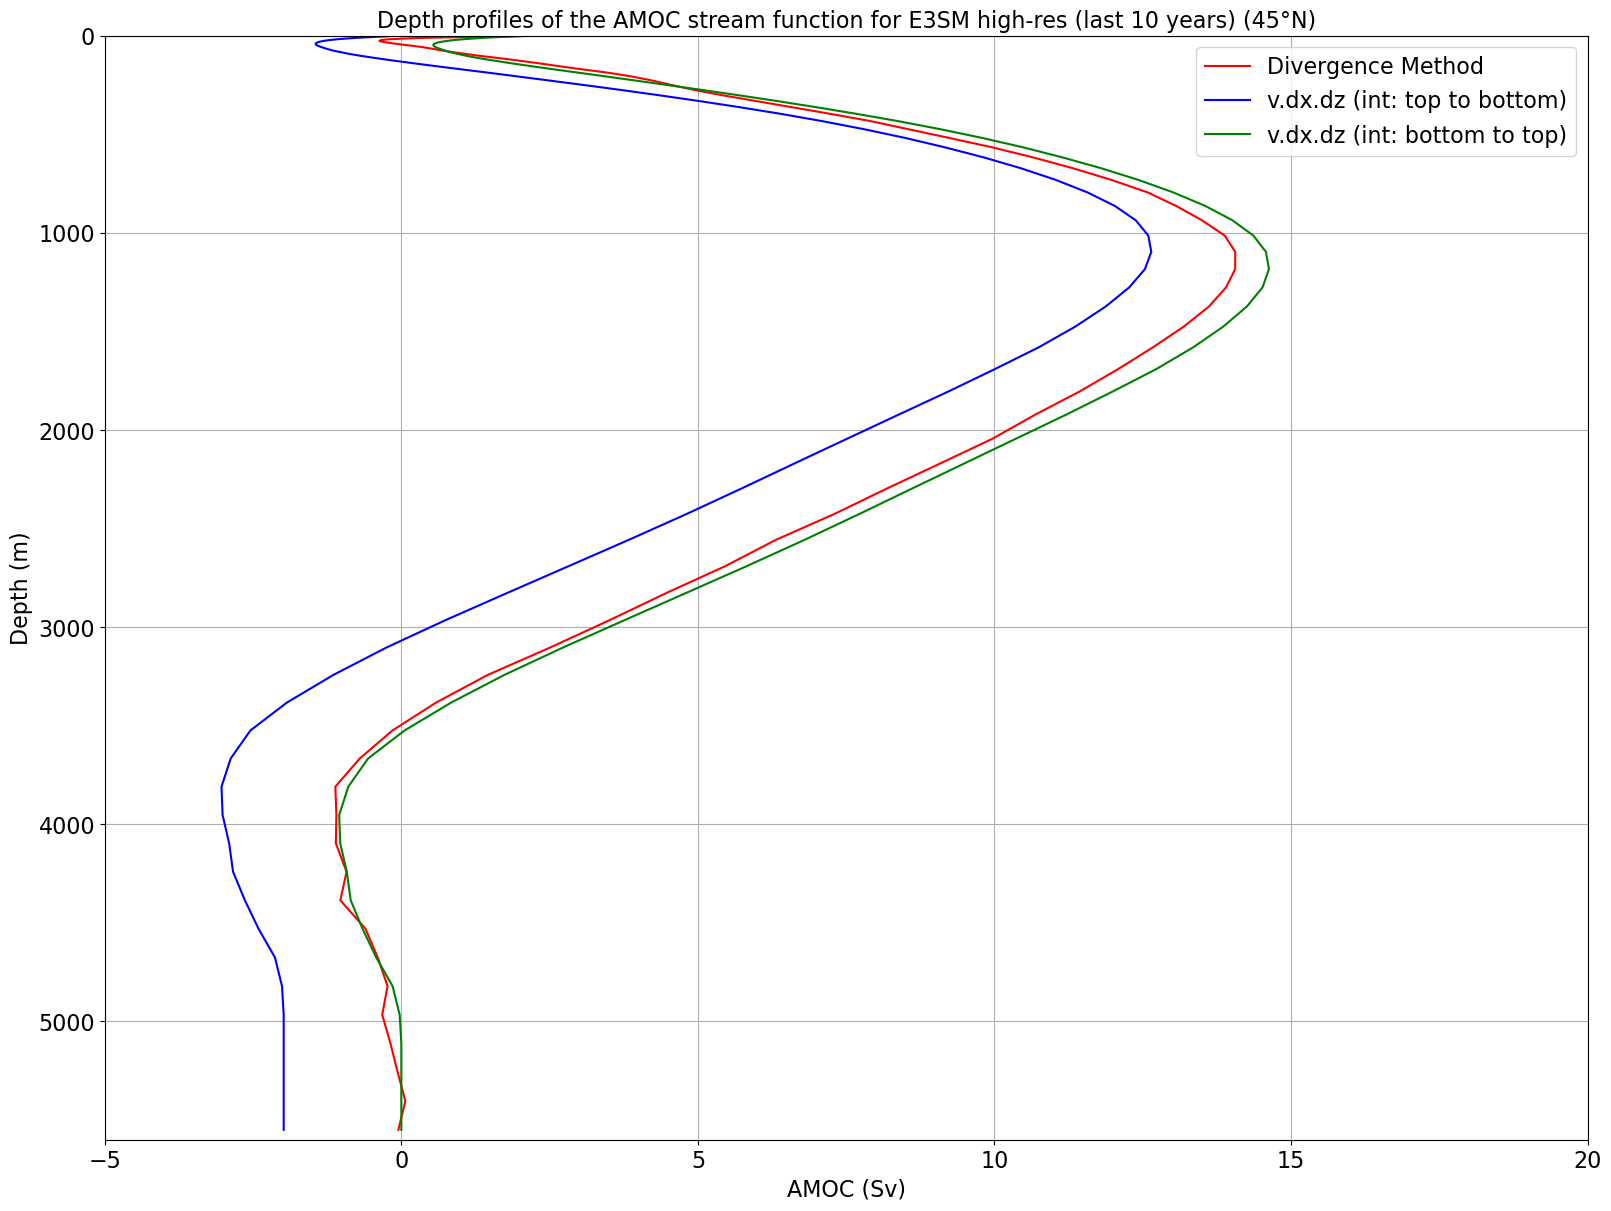

In [119]:
plt.figure(figsize=(16, 12))
plt.plot(amoc_sel_da[:,3],lev, label='Divergence Method',c='r')
plt.plot(amoc_sel_dxdz_tb[:,3],lev, label='v.dx.dz (int: top to bottom)',c='b')
plt.plot(amoc_sel_dxdz_bt[:,3],lev, label='v.dx.dz (int: bottom to top)',c='g')
plt.grid()
plt.xlim(-5,20)
plt.ylim(5600,0)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('AMOC (Sv)',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
plt.legend(fontsize=16)
plt.title('Depth profiles of the AMOC stream function for E3SM high-res (last 10 years) (45°N)',fontsize=16)
plt.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_depth_profile_45N', dpi=300)

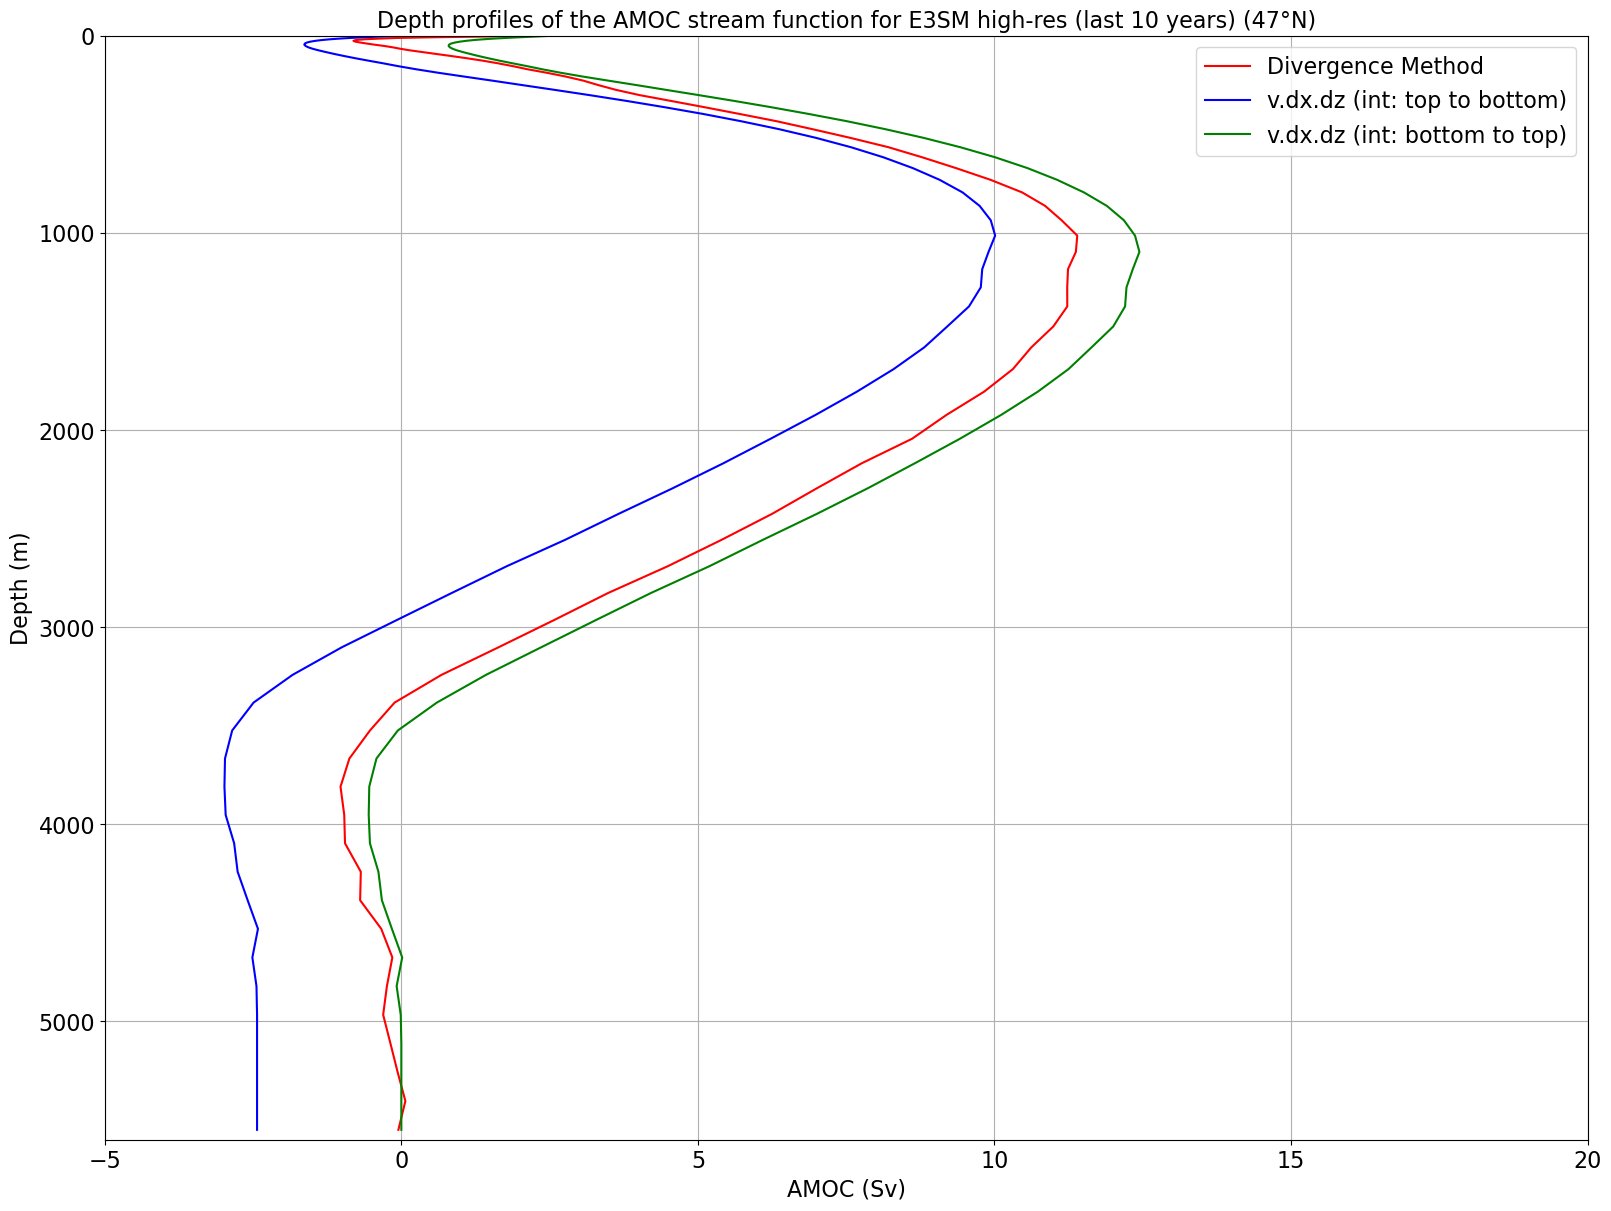

In [120]:
plt.figure(figsize=(16, 12))
plt.plot(amoc_sel_da[:,4],lev, label='Divergence Method',c='r')
plt.plot(amoc_sel_dxdz_tb[:,4],lev, label='v.dx.dz (int: top to bottom)',c='b')
plt.plot(amoc_sel_dxdz_bt[:,4],lev, label='v.dx.dz (int: bottom to top)',c='g')
plt.grid()
plt.xlim(-5,20)
plt.ylim(5600,0)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('AMOC (Sv)',fontsize=16)
plt.ylabel('Depth (m)',fontsize=16)
plt.legend(fontsize=16)
plt.title('Depth profiles of the AMOC stream function for E3SM high-res (last 10 years) (47°N)',fontsize=16)
plt.tight_layout(pad=0.3)
plt.savefig('/pscratch/sd/a/abhi305/Plots/AMOC_depth_profile_47N', dpi=300)